In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.tsa.statespace as tm_models
from datetime import datetime,time

In [3]:
df = pd.read_excel(r"D:\excelr assignments\forecasting\CocaCola_Sales_Rawdata.xlsx")

In [4]:
df.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [5]:
df.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [6]:
df.dtypes

Quarter     object
Sales      float64
dtype: object

In [7]:
df.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [8]:
df['Quarter'] = df['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))
df['Quarter'] = pd.to_datetime(df['Quarter'].str.split(' ').apply(lambda x:''.join(x[::-1])),dayfirst=True)

In [9]:
df['Year'] = pd.DatetimeIndex(df['Quarter']).year

In [10]:
df['month'] = pd.DatetimeIndex(df['Quarter']).month

In [11]:
import calendar

In [12]:
df['month'] = df['month'].apply(lambda x: calendar.month_name[x])

In [13]:
month_dummies = pd.get_dummies(df['month'])
df = pd.concat([df,month_dummies],axis=1)

In [14]:
df.head()

,Quarter,Sales,Year,month,April,January,July,October
0,1986-01-01,1734.827000,1986,January,0,1,0,0
1,1986-04-01,2244.960999,1986,April,1,0,0,0
2,1986-07-01,2533.804993,1986,July,0,0,1,0
3,1986-10-01,2154.962997,1986,October,0,0,0,1
4,1987-01-01,1547.818996,1987,January,0,1,0,0


In [15]:
df.dtypes

Quarter    datetime64[ns]
Sales             float64
Year                int64
month              object
April               uint8
January             uint8
July                uint8
October             uint8
dtype: object

<AxesSubplot:>

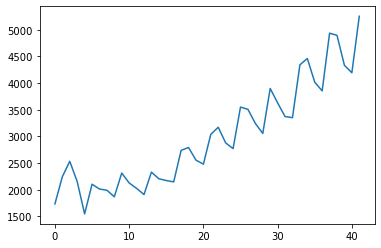

In [16]:
df['Sales'].plot()

<AxesSubplot:ylabel='Density'>

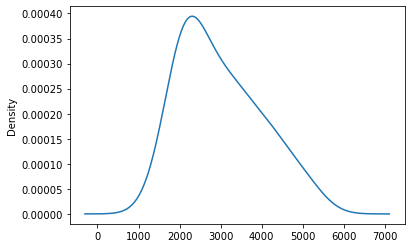

In [17]:
df['Sales'].plot(kind='kde')

<AxesSubplot:>

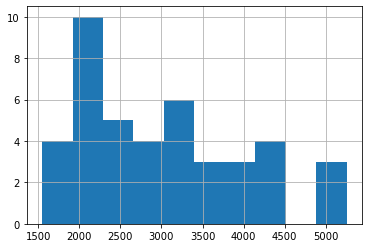

In [18]:
df['Sales'].hist()

<AxesSubplot:xlabel='Year', ylabel='Sales'>

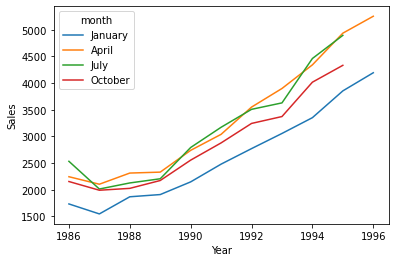

In [76]:
sns.lineplot(x="Year",y="Sales",hue="month",data=df)

<AxesSubplot:xlabel='Year', ylabel='Sales'>

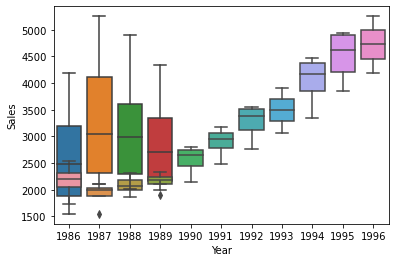

In [77]:
sns.boxplot(x="month",y="Sales",data=df)
sns.boxplot(x="Year",y="Sales",data=df)

<AxesSubplot:xlabel='month', ylabel='Year'>

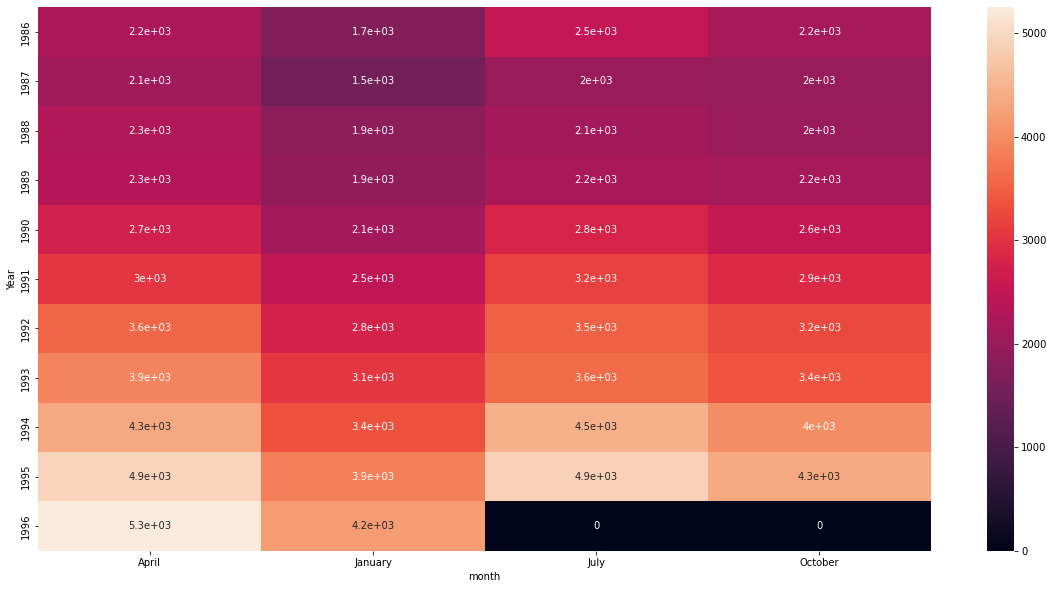

In [78]:
plt.figure(figsize=(20,10))
heatmap = pd.pivot_table(data=df,aggfunc='mean',fill_value=0,values='Sales',index='Year',columns='month')
sns.heatmap(heatmap,annot=True)

<Figure size 3600x1080 with 0 Axes>

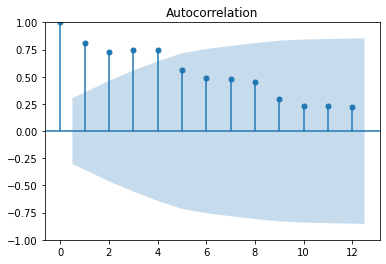

In [53]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plt.figure(figsize = (50,15))
plot_acf(df['Sales'], lags=12)
plt.show()

C:\Users\lokit\anaconda3\anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 3600x1080 with 0 Axes>

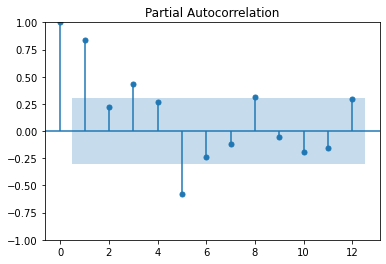

In [54]:
plt.figure(figsize = (50,15))
plot_pacf(df['Sales'], lags=12)
plt.show()

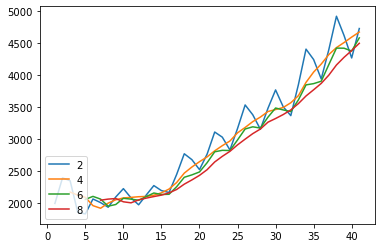

In [20]:
for i in range(2,10,2):
    df["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)

In [21]:
df.set_index('Quarter',inplace=True)

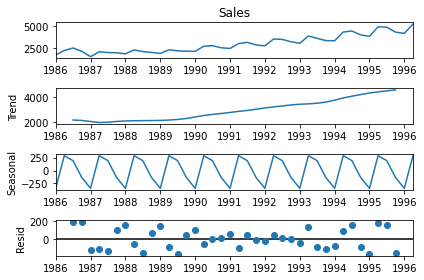

In [22]:
ts_add = seasonal_decompose(df.Sales,model="additive")
fig = ts_add.plot()
plt.show()

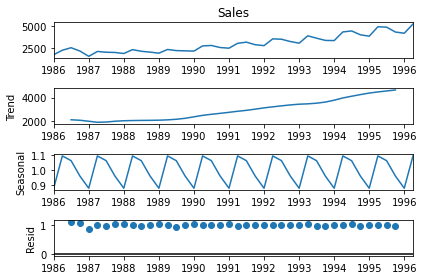

In [23]:
ts_mul = seasonal_decompose(df.Sales,model="multiplicative")
fig = ts_mul.plot()
plt.show()

In [24]:
df.shape

(42, 7)

In [25]:
df['t'] = np.arange(1,43)

In [26]:
df['t_squared'] = df['t']*df['t']

In [27]:
df['log_sales'] = np.log(df['Sales'])

In [28]:
Train = df.head(84)
Test = df.tail(12)

In [29]:
# L I N E A R #

In [30]:
import statsmodels.formula.api as smf 

linear_model = smf.ols('Sales~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_linear))**2))
rmse_linear

449.799622612296

In [31]:
# Exponential #

In [32]:
exp = smf.ols('log_sales~t',data=Train).fit()
pred_exp = pd.Series(exp.predict(pd.DataFrame(Test['t'])))
rmse_exp = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_exp)))**2))
rmse_exp

417.560828374984

In [33]:
# Quadratic #

In [34]:
quad = smf.ols('Sales~t+t_squared',data=Train).fit()
pred_quad = pd.Series(quad.predict(Test[["t","t_squared"]]))
rmse_quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_quad))**2))
rmse_quad

394.75561592700984

In [35]:
# Additive seasonality #

In [41]:
Test['April']

Quarter
1993-07-01    0
1993-10-01    0
1994-01-01    0
1994-04-01    1
1994-07-01    0
1994-10-01    0
1995-01-01    0
1995-04-01    1
1995-07-01    0
1995-10-01    0
1996-01-01    0
1996-04-01    1
Name: April, dtype: uint8

In [42]:
add_s = smf.ols('Sales~April+January+July+October',data=Train).fit()
pred_add_s = pd.Series(add_s.predict(Test[['April','January','July','October']]))
rmse_add_s = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_s))**2))
rmse_add_s

1305.6638874921084

In [43]:
# Additive Seasonality Quadratic #

In [44]:
add_sea_q = smf.ols('Sales~t+t_squared+January+April+July+October',data=Train).fit()
pred_add_sea_q = pd.Series(add_sea_q.predict(Test[['April','January','July','October','t','t_squared']]))
rmse_add_sea_q = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea_q))**2))
rmse_add_sea_q 

170.42727210326288

In [45]:
# Multiplicative Seasonality #

In [46]:
mul_sea = smf.ols('log_sales~January+April+July+October',data = Train).fit()
pred_mult_sea = pd.Series(mul_sea.predict(Test))
rmse_mult_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_mult_sea)))**2))
rmse_mult_sea

1435.5011310008856

In [47]:
#Multiplicative Additive Seasonality #

In [48]:
mul_add_sea = smf.ols('log_sales~t+January+April+July+October',data = Train).fit()
pred_mult_add_sea = pd.Series(mul_add_sea.predict(Test))
rmse_mult_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_mult_add_sea)))**2))
rmse_mult_add_sea 


172.1505688393052

In [49]:
# Testing #

In [50]:
data = {"MODEL":pd.Series(["rmse_linear","rmse_exp","rmse_quad","rmse_add_s","rmse_add_sea_q","rmse_mult_sea","rmse_mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_exp,rmse_quad,rmse_add_s,rmse_add_sea_q,rmse_mult_sea,rmse_mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse

,MODEL,RMSE_Values
0,rmse_linear,449.799623
1,rmse_exp,417.560828
2,rmse_quad,394.755616
3,rmse_add_s,1305.663887
4,rmse_add_sea_q,170.427272
5,rmse_mult_sea,1435.501131
6,rmse_mult_add_sea,172.150569


In [ ]:
#Additive Seasonality Quadratic has the least rmse value

In [51]:
model_full = smf.ols('Sales~t+t_squared+January+April+July+October',data=df).fit()

pred_new  = pd.Series(model_full.predict(df))
pred_new

df["forecasted_sales"] = pd.Series(pred_new)

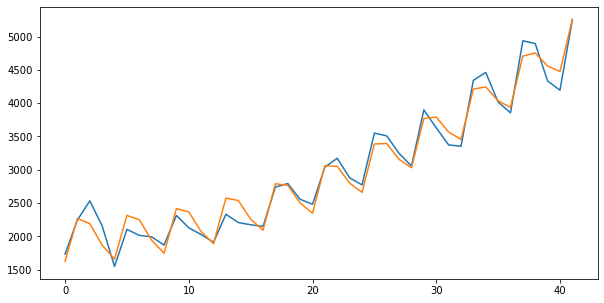

In [55]:
plt.figure(figsize=(10,5))
plt.plot(df[['Sales','forecasted_sales']].reset_index(drop=True))

In [56]:
# Additive Seasonality Quadratic has the least value

In [57]:
# Creating a function to calculate the MAPE value for test data 
def MAPE(pred,org):
    temp = np.abs((pred-org))*100/org
    return np.mean(temp)

In [58]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing 
from statsmodels.tsa.holtwinters import Holt 
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [59]:
# Simple Exponential Method
ses_model = SimpleExpSmoothing(Train["Sales"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Sales)


C:\Users\lokit\anaconda3\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


11.039054157997752

In [60]:
# Holt method 
hw_model = Holt(Train["Sales"]).fit(smoothing_trend=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Sales) 

C:\Users\lokit\anaconda3\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


11.343597428780532

In [61]:
# Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=12,damped=True).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Sales) 


C:\Users\lokit\AppData\Local\Temp\ipykernel_22412\542473508.py:2: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=12,damped=True).fit()
C:\Users\lokit\anaconda3\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


3.8092449500536785

In [62]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Sales) 

C:\Users\lokit\anaconda3\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


1.797902167081796

In [63]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend gives least value

In [64]:
#Final model

In [65]:
hwe_model_mul_add = ExponentialSmoothing(df["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit()

C:\Users\lokit\anaconda3\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [66]:
hwe_model_mul_add.forecast(12)

1996-07-01    5012.147440
1996-10-01    4645.260903
1997-01-01    4490.053377
1997-04-01    5638.551712
1997-07-01    5671.720685
1997-10-01    5107.131442
1998-01-01    4834.680254
1998-04-01    6127.684114
1998-07-01    6109.530409
1998-10-01    5503.868389
1999-01-01    5100.552492
1999-04-01    6447.534541
Freq: QS-OCT, dtype: float64